In [1]:
import pandas as pd
import os


In [2]:
filenames = os.listdir(os.getcwd())
csv_filenames = [f for f in filenames if f.endswith('csv')]

In [3]:
filenames

['g60_conductive_1.csv',
 'g60_conductive_2.csv',
 'g60_conductive_3.csv',
 'g60_nonconductive_1.csv',
 'g60_nonconductive_2.csv',
 'g60_nonconductive_3.csv',
 'hmwg_nonconductive_1.csv',
 'hmwg_nonconductive_2.csv',
 'hmwg_nonconductive_3.csv',
 'pristine_conductive_1.csv',
 'pristine_conductive_2.csv',
 'pristine_conductive_3.csv',
 'pristine_nonconductive_1.csv',
 'pristine_nonconductive_2.csv',
 'pristine_nonconductive_3.csv',
 '.ipynb_checkpoints',
 'plot_stress_strain.ipynb',
 'hmwg_conductive_1.csv',
 'hmwg_conductive_2.csv',
 'hmwg_conductive_3.csv',
 'hysteresis.pdf',
 'resilience.pdf']

In [4]:
all_data = []
for filename in csv_filenames:
    # Step 1: Read the first two rows to get column names and units
    first_rows = pd.read_csv(filename, nrows=1)
    
    # Step 2: Combine column names with units
    columns_with_units = [f'{col} {unit}' for col, unit in zip(first_rows.columns, first_rows.iloc[0])]
    
    # Step 3: Read the CSV file, skipping the first two rows and applying the new column names
    data = pd.read_csv(filename, skiprows=2, names=first_rows.columns)
    
    # Step 4: Process the filenames to extract specimen, conductivity, and sample number
    # Assuming filename format is 'specimen_conductivity_samplenumber.csv'
    specimen, conductivity, sample_number = filename.replace('.csv', '').split('_')
    # Add a new column to the DataFrame for specimen, conductivity, and sample number
    data['Specimen'] = specimen
    data['Conductivity'] = conductivity
    data['SampleNumber'] = int(sample_number)
    
    # Append the DataFrame to our list of all data
    all_data.append(data)

# Combine all data into a single DataFrame
combined_data = pd.concat(all_data, ignore_index=True)

In [5]:
def mark_cycles_based_on_increase(data):
    # Ensure data is sorted by time, assuming 'Time' is your temporal column
    data = data.sort_values(by='Time').reset_index(drop=True)
    # Detect points where strain decreases
    decrease = data['Strain'].diff() < 0
    # Detect points where strain starts to increase again
    increase = data['Strain'].diff() > 0
    
    # Initialize a cycle marker, starting all as cycle 0
    data['Cycle'] = 0
    cycle = 0
    # Flag to mark the beginning of searching for an increase after a decrease
    looking_for_increase = False
    
    for i in range(1, len(data)):
        if decrease[i] and not looking_for_increase:
            # Once we see a decrease, we start looking for an increase
            looking_for_increase = True
        elif increase[i] and looking_for_increase:
            # Once we find an increase after a decrease, we mark a new cycle
            cycle += 1
            looking_for_increase = False
        # Mark the current cycle number
        data.at[i, 'Cycle'] = cycle

    return data

# Apply the function to each subset of the data
combined_data = combined_data.groupby(['Specimen', 'Conductivity', 'SampleNumber']).apply(mark_cycles_based_on_increase).reset_index(drop=True)


/tmp/ipykernel_2776/1680438895.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_data = combined_data.groupby(['Specimen', 'Conductivity', 'SampleNumber']).apply(mark_cycles_based_on_increase).reset_index(drop=True)


In [6]:
label_dict = {"pristine": "PG", "hmwg":"CG", "g60":"GG", "conductive":"C", "nonconductive":"NC"}

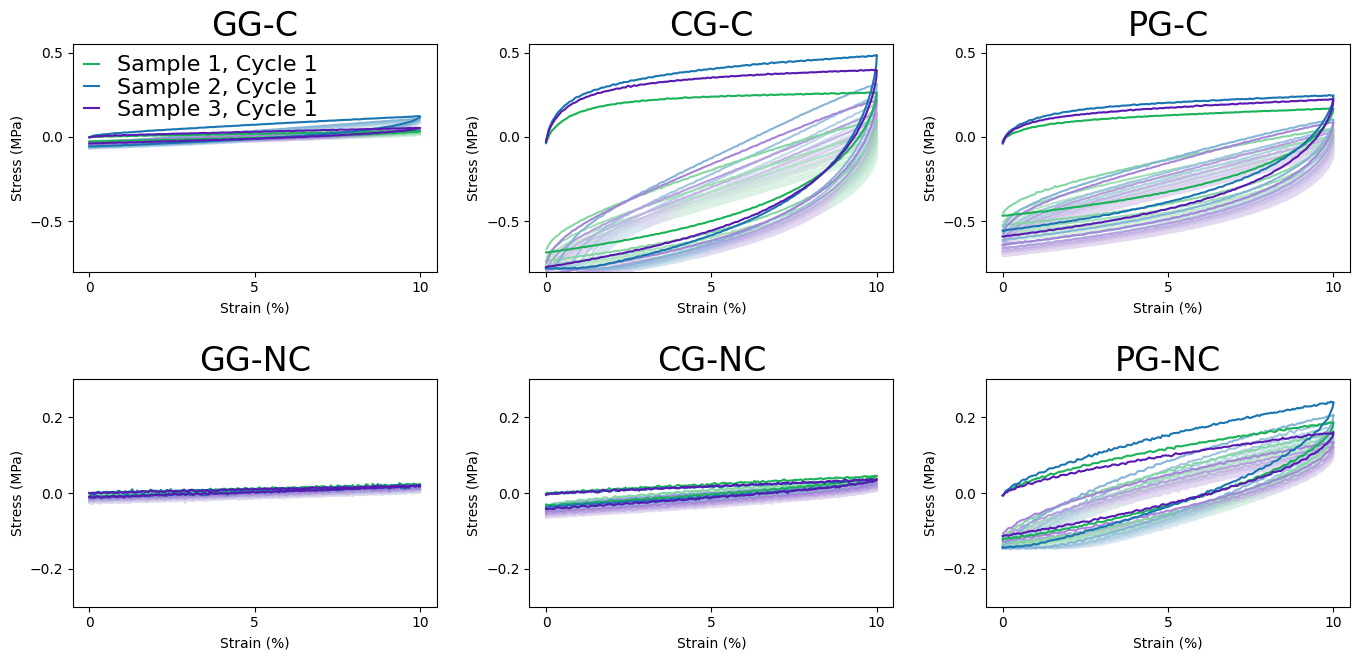

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import colorsys

def hsl_to_rgb(h, s, l):
    """Convert HSL color space to RGB color space."""
    return colorsys.hls_to_rgb(h, l, s)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 7))
plt.subplots_adjust(wspace=None, hspace=None)

axes = axes.flatten()
plt.rcParams.update({'font.size': 20})
unique_combinations = combined_data.drop_duplicates(subset=['Specimen', 'Conductivity'])

order = [0,3,1,4,2,5]
#order = [0,1,2,3,4,5]
for i, (index, row) in enumerate(unique_combinations.iterrows()):
    ax = axes[order[i]]
    current_data = combined_data[(combined_data['Specimen'] == row['Specimen']) &
                                 (combined_data['Conductivity'] == row['Conductivity'])]
    
    sample_numbers = current_data['SampleNumber'].unique()
    cycles = sorted(current_data['Cycle'].unique(), reverse=True)
    hues = np.linspace(0.4, 0.9, len(sample_numbers)+1)[:-1]  # Normalize hue across sample numbers

    for cycle in cycles:
        saturation_decrease_factor = 0.5 * (0.99**cycle)   # Decrease saturation with each cycle
        lightness_decrease_factor = 0.4 * (0.8**cycle)  # Decrease lightness with each cycle
        if cycle ==0:
            saturation_decrease_factor = saturation_decrease_factor * 1.5
            lightness_decrease_factor = lightness_decrease_factor * 1.5
        for hue, sample_number in zip(hues, sample_numbers):
            sample_data = current_data[current_data['SampleNumber'] == sample_number]
            cycle_data = sample_data[sample_data['Cycle'] == cycle]
            
            # Apply decrease factors, ensuring they don't fall below a minimum value
            saturation = max(0.2, saturation_decrease_factor)
            lightness = max(0.1, lightness_decrease_factor)  # Keep lightness within a reasonable range
            
            color = hsl_to_rgb(hue, saturation, 1-lightness)
            
            label = f'Sample {sample_number}, Cycle {cycle+1}' if cycle == 0 else None
            ax.plot(cycle_data['Strain']*100, cycle_data['Stress'], color=color, label=label)
    conductivity = label_dict[row["Conductivity"]]
    if conductivity=="C":
        ax.set_ylim((-0.8,0.55))
    else:
        ax.set_ylim((-0.3,0.3))
    ax.set_title(f'{label_dict[row["Specimen"]]}-{conductivity}')
    ax.set_xlabel('Strain (%)')
    ax.set_ylabel('Stress (MPa)')
    if i == 0:  # Optionally, customize the legend for clarity
        ax.legend(fontsize=16, frameon=False, handlelength=0.7, labelspacing=0.1, borderpad=0)
        pass


plt.tight_layout()
plt.savefig("hysteresis.pdf", format="pdf", bbox_inches="tight")
plt.show()



In [8]:
def calculate_resilience(data):
    loading_areas = []
    unloading_areas = []
    for cycle in data['Cycle'].unique():
        cycle_data = data[data['Cycle'] == cycle]
        for i in range(len(cycle_data) - 1):
            # Calculate the area of the trapezoid between consecutive points
            dx = abs(cycle_data.iloc[i+1]['Strain'] - cycle_data.iloc[i]['Strain'])
            dy = (cycle_data.iloc[i+1]['Stress'] + cycle_data.iloc[i]['Stress']) / 2
            area = dx * dy
            
            if cycle_data.iloc[i+1]['Strain'] > cycle_data.iloc[i]['Strain']:
                loading_areas.append(area)  # Strain increasing
            else:
                unloading_areas.append(area)  # Strain decreasing
    return sum(loading_areas), sum(unloading_areas)
    
# Function to adjust stress values for a given DataFrame
def adjust_stress_values(group):
    min_stress = group['Stress'].min()
    if min_stress < 0:
        group['Stress'] += -min_stress  # Add the absolute value of the minimum stress
    return group

# Apply the function to each trial
combined_data = combined_data.groupby(['Specimen', 'Conductivity', 'SampleNumber']).apply(adjust_stress_values).reset_index(drop=True)

# Proceed with the adjusted_data for resilience calculation

# Apply the resilience calculation for each specimen x composition
resilience_data = []
for (specimen, conductivity, sample_num), group_data in combined_data.groupby(['Specimen', 'Conductivity', 'SampleNumber']):
    loading, unloading = calculate_resilience(group_data)
    resilience_data.append({'Specimen': specimen, 'Conductivity': conductivity, 'Sample': sample_num, 'Loading': loading, 'Unloading': unloading})

resilience_df = pd.DataFrame(resilience_data)


/tmp/ipykernel_2776/3296295631.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_data = combined_data.groupby(['Specimen', 'Conductivity', 'SampleNumber']).apply(adjust_stress_values).reset_index(drop=True)


In [9]:
resilience_df['Unloading/Loading Ratio (%)'] = (resilience_df['Unloading'] / resilience_df['Loading']) * 100
resilience_stats = resilience_df.groupby(['Specimen', 'Conductivity'])['Unloading/Loading Ratio (%)'].agg(['mean', 'std']).reset_index()

resilience_df

,Specimen,Conductivity,Sample,Loading,Unloading,Unloading/Loading Ratio (%)
0,g60,conductive,1,0.040714,0.031026,76.206021
1,g60,conductive,2,0.094879,0.055462,58.455055
2,g60,conductive,3,0.055069,0.036091,65.536550
3,g60,nonconductive,1,0.023264,0.019846,85.306531
4,g60,nonconductive,2,0.024010,0.020873,86.936706
5,g60,nonconductive,3,0.023667,0.020345,85.966422
6,hmwg,conductive,1,0.517397,0.249218,48.167779
7,hmwg,conductive,2,0.546993,0.202293,36.982780
8,hmwg,conductive,3,0.570549,0.239171,41.919481
9,hmwg,nonconductive,1,0.054375,0.040297,74.109441


In [10]:
resilience_stats['std']

0    8.935715
1    0.819998
2    5.605302
3    0.944601
4    1.845194
5    4.096271
Name: std, dtype: float64

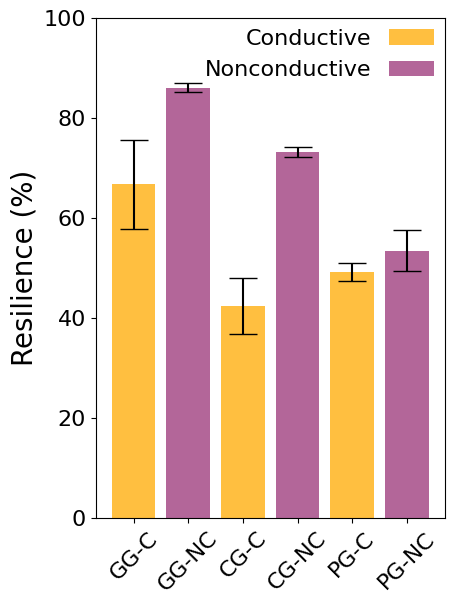

In [13]:

plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(4.5, 6.5))
# Generate labels from specimen and conductivity
labels = [f"{label_dict[specimen]}-{label_dict[conductivity]}" for specimen, conductivity in zip(resilience_stats['Specimen'],resilience_stats['Conductivity'])]

colors = [ (1,0.75,0.25), (0.7,0.4,0.6)]
features = ['Conductive', 'Nonconductive']
for c,l in zip(colors, features):
    plt.bar([1],[1], color = c, label=l)#dummy bar for lagend
plt.legend(loc="upper right", fontsize=16, borderpad=0, frameon=False, markerfirst=False)

#ax.bar(labels, resilience_df['Unloading/Loading Ratio (%)'])
bars=ax.bar(labels, resilience_stats['mean'], yerr=resilience_stats['std'], capsize=10, color=colors*3 )

plt.ylim((0,100))
#ax.set_xlabel('Specimen x Composition')
ax.set_ylabel('Resilience (%)', fontsize=20)
#ax.set_title('Resilience')
plt.xticks(rotation=45)  # Rotate labels to fit
plt.savefig("resilience.pdf")
plt.show()